### Intro to LlamaIndex  
Sources: [1](https://docs.llamaindex.ai/en/stable/understanding/rag/), [2](https://docs.llamaindex.ai/en/stable/), [3](https://github.com/run-llama/llama_index), [4](https://nanonets.com/blog/llamaindex/), [5](https://betterprogramming.pub/llamaindex-how-to-use-index-correctly-6f928b8944c6)  

#### Retrieval Augmented Generation (RAG)
LLMs are trained on enormous bodies of data but they aren’t trained on your data. Retrieval-Augmented Generation (RAG) solves this problem by adding your data to the data LLMs already have access to. You will see references to RAG frequently in this documentation.  
In RAG, your data is loaded and prepared for queries or “indexed”. User queries act on the index, which filters your data down to the most relevant context. This context and your query then go to the LLM along with a prompt, and the LLM provides a response.  
Even if what you’re building is a chatbot or an agent, you’ll want to know RAG techniques for getting data into your application.  

#### Stages within RAG
There are five key stages within RAG, which in turn will be a part of any larger application you build. These are:
+ Loading: this refers to getting your data from where it lives – whether it’s text files, PDFs, another website, a database, or an API – into your pipeline. LlamaHub provides hundreds of connectors to choose from.
+ Indexing: this means creating a data structure that allows for querying the data. For LLMs this nearly always means creating vector embeddings, numerical representations of the meaning of your data, as well as numerous other metadata strategies to make it easy to accurately find contextually relevant data.
+ Storing: once your data is indexed you will almost always want to store your index, as well as other metadata, to avoid having to re-index it.
+ Querying: for any given indexing strategy there are many ways you can utilize LLMs and LlamaIndex data structures to query, including sub-queries, multi-step queries and hybrid strategies.
+ Evaluation: a critical step in any pipeline is checking how effective it is relative to other strategies, or when you make changes. Evaluation provides objective measures of how accurate, faithful and fast your responses to queries are.

#### Important concepts within each step
There are also some terms you’ll encounter that refer to steps within each of these stages.  
+ Loading stage
**Nodes** and **Documents**: A Document is a container around any data source - for instance, a PDF, an API output, or retrieve data from a database.  
A Node is the atomic unit of data in LlamaIndex and represents a “chunk” of a source Document. Nodes have metadata that relate them to the document they are in and to other nodes.  
**Connectors**: A data connector (often called a Reader) ingests data from different data sources and data formats into Documents and Nodes.  

+ Indexing Stage  
**Indexes**: Once you’ve ingested your data, LlamaIndex will help you index the data into a structure that’s easy to retrieve. This usually involves generating vector embeddings which are stored in a specialized database called a vector store. Indexes can also store a variety of metadata about your data.  
**Embeddings** LLMs generate numerical representations of data called embeddings. When filtering your data for relevance, LlamaIndex will convert queries into embeddings, and your vector store will find data that is numerically similar to the embedding of your query.  

+ Querying Stage
**Retrievers**: A retriever defines how to efficiently retrieve relevant context from an index when given a query. Your retrieval strategy is key to the relevancy of the data retrieved and the efficiency with which it’s done.  
**Routers**: A router determines which retriever will be used to retrieve relevant context from the knowledge base. More specifically, the RouterRetriever class, is responsible for selecting one or multiple candidate retrievers to execute a query. They use a selector to choose the best option based on each candidate’s metadata and the query.  
Node Postprocessors: A node postprocessor takes in a set of retrieved nodes and applies transformations, filtering, or re-ranking logic to them.  
Response Synthesizers: A response synthesizer generates a response from an LLM, using a user query and a given set of retrieved text chunks.  

#### Putting it all together
There are endless use cases for data-backed LLM applications but they can be roughly grouped into three categories:

+ Query Engines: A query engine is an end-to-end pipeline that allows you to ask questions over your data. It takes in a natural language query, and returns a response, along with reference context retrieved and passed to the LLM.
+ Chat Engines: A chat engine is an end-to-end pipeline for having a conversation with your data (multiple back-and-forth instead of a single question-and-answer).
+ Agents: An agent is an automated decision-maker powered by an LLM that interacts with the world via a set of tools. Agents can take an arbitrary number of steps to complete a given task, dynamically deciding on the best course of action rather than following pre-determined steps. This gives it additional flexibility to tackle more complex tasks.  

### Customizing a RAG Pipeline:

![](https://docs.llamaindex.ai/en/stable/_static/getting_started/basic_rag.png)

#### Installing Packages

In [ ]:

!pip install -qU pip
!pip install -qU openai
!pip install -qU google-genai
!pip install -qU llama-index
!pip install -qU llama-index-core
!pip install -qU llama-index-experimental
!pip install -qU llama-index-llms-openai
!pip install -qU llama-index-llms-ollama
!pip install -qU llama-index-embeddings-ollama
!pip install -qU llama_index.embeddings.huggingface
!pip install -qU llama-index-embeddings-instructor
!pip install -qU llama-index-postprocessor-colbert-rerank
!pip install -qU torch
!pip install -qU pydantic
!pip install -qU pypdf
!pip install -qU docx2txt
!pip install -qU python-dotenv

#### Importing Packages

In [8]:
import os
import sys
import shutil
import glob
import logging
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import pydantic
from dotenv import load_dotenv
import openai
from google import genai

load_dotenv("../../.env", override=True)

import nest_asyncio 
nest_asyncio.apply()
#nest_asyncio.suppress()

In [9]:
import logging

#logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
#logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

In [10]:
#os.environ["OPENAI_API_KEY"] = "<the key>"
#openai.api_key = os.environ["OPENAI_API_KEY"]
openai.api_key = os.getenv('OPENAI_API_KEY')
client = openai.OpenAI()

### Defining Models

[Hugging Face Models](https://docs.llamaindex.ai/en/stable/examples/embeddings/huggingface/)  
[Ollama Models](https://ollama.com/search)

In [6]:
import llama_index

from llama_index.core.callbacks import CallbackManager
from llama_index.core.callbacks import LlamaDebugHandler
from llama_index.core import Settings
from llama_index.llms.openai import OpenAI
from llama_index.llms.ollama import Ollama
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

#model="gpt-3.5-turbo"
#model="gpt-4o"
#model="gpt-4o-mini"
model="gpt-5-nano"

Settings.llm = OpenAI(temperature=0, model=model, PRESENCE_PENALTY=-2, TOP_P=1,)
#Settings.llm = Ollama(model="llama3.2:1b", request_timeout=3600.0)

Settings.embed_model = OpenAIEmbedding(model="text-embedding-ada-002")
#Settings.embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")

In [11]:
print("LLamaIndex:", llama_index.core.__version__)
print("Pydantic:", pydantic.VERSION)
print("OpenAI:", openai.__version__)

LLamaIndex: 0.14.12
Pydantic: 2.12.5
OpenAI: 2.15.0


#### Defining and Examining Folders

In [13]:
DOCS_DIR = "../../Data/"
PERSIST_DIR = "../../Index/"

print(f"Current dir: {os.getcwd()}")

if not os.path.exists(DOCS_DIR):
  os.mkdir(DOCS_DIR)
docs = os.listdir(DOCS_DIR)
docs = [d for d in docs]
docs.sort()
print(f"Files in {DOCS_DIR}")
for doc in docs:
    print(doc)

Current dir: /home/renato/Documents/Repos/GenAI4Humanists/Notebooks/LlamaIndex
Files in ../../Data/
.ipynb_checkpoints
RAG_images
Vienna_dataset.json
csv
hr.sqlite
html
imgs
mp3
new_rag_dataset.json
pdf
txt


### Documents and Nodes

### [Documents](https://docs.llamaindex.ai/en/stable/module_guides/loading/documents_and_nodes/usage_documents/)

In [14]:
from llama_index.core import Document

text_list = [f"{DOCS_DIR}kafka_metamorphosis.txt", f"{DOCS_DIR}paul_graham_essay.txt",]
documents = [Document(text=t) for t in text_list]

# build index
#tmp_index = VectorStoreIndex.from_documents(documents)

documents

[Document(id_='f1c94675-0b32-43e6-a574-5a4e6c00b04c', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, metadata_template='{key}: {value}', metadata_separator='\n', text_resource=MediaResource(embeddings=None, data=None, text='../../Data/kafka_metamorphosis.txt', path=None, url=None, mimetype=None), image_resource=None, audio_resource=None, video_resource=None, text_template='{metadata_str}\n\n{content}'),
 Document(id_='fcf69da4-3df7-4a92-924e-3bab36610e07', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, metadata_template='{key}: {value}', metadata_separator='\n', text_resource=MediaResource(embeddings=None, data=None, text='../../Data/paul_graham_essay.txt', path=None, url=None, mimetype=None), image_resource=None, audio_resource=None, video_resource=None, text_template='{metadata_str}\n\n{content}')]

#### By default, all data loaders (including those offered on LlamaHub) return Document objects through the load_data function.

In [15]:
from llama_index.core import SimpleDirectoryReader

documents = SimpleDirectoryReader(input_files=[f"{DOCS_DIR}/txt/paul_graham_essay.txt"]).load_data() 
documents

[Document(id_='3a8deabb-a8dc-4ad8-b661-1979c236f09f', embedding=None, metadata={'file_path': '../../Data/txt/paul_graham_essay.txt', 'file_name': 'paul_graham_essay.txt', 'file_type': 'text/plain', 'file_size': 75042, 'creation_date': '2025-04-04', 'last_modified_date': '2025-04-04'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, metadata_template='{key}: {value}', metadata_separator='\n', text_resource=MediaResource(embeddings=None, data=None, text='\n\nWhat I Worked On\n\nFebruary 2021\n\nBefore college the two main things I worked on, outside of school, were writing and programming. I didn\'t write essays. I wrote what beginning writers were supposed to write then, and probably still are: short stories. My stories were awful. They had hardly any plot, jus

### [Nodes](https://docs.llamaindex.ai/en/stable/module_guides/loading/documents_and_nodes/usage_nodes/) and [Node Parsers](https://docs.llamaindex.ai/en/stable/module_guides/loading/node_parsers/modules/)

In [16]:
from llama_index.core.schema import Node
from llama_index.core.node_parser import SentenceSplitter
#from llama_index.core.node_parser import TokenTextSplitter
#from llama_index.core.node_parser import HTMLNodeParser
#from llama_index.core.node_parser import JSONNodeParser
#from llama_index.core.node_parser import MarkdownNodeParser
#from llama_index.core.node_parser import CodeSplitter
from llama_index.core.node_parser import SemanticSplitterNodeParser
#from llama_index.embeddings.openai import OpenAIEmbedding
#from llama_index.core.ingestion import IngestionPipeline

## parse nodes

#node_parser = SentenceSplitter(chunk_size=512, chunk_overlap=20)
node_parser = SemanticSplitterNodeParser(
    buffer_size=1,  # Number of sentences to group together
    embed_model=Settings.embed_model,
    breakpoint_percentile_threshold=95  # Threshold for semantic breaks
)

nodes = node_parser.get_nodes_from_documents(documents, show_progress=True)

# build index
#tmp_index = VectorStoreIndex(nodes)

print(len(nodes))

for n in nodes:
    print(n)
    break

Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/757 [00:00<?, ?it/s]

2026-01-16 15:04:23,694 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 15:04:24,603 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 15:04:26,073 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 15:04:26,707 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 15:04:28,052 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 15:04:29,336 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 15:04:30,622 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 15:04:31,705 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


39
Node ID: dae5f2a9-c787-452f-b4d5-535c955d4d0c
Text: What I Worked On  February 2021  Before college the two main
things I worked on, outside of school, were writing and programming. I
didn't write essays.


### See also: [Conectors](https://docs.llamaindex.ai/en/stable/module_guides/loading/connector/) and [LlamaHub](https://llamahub.ai/)

### [Indexes](https://docs.llamaindex.ai/en/stable/module_guides/indexing/indexing.html)    
[API](https://docs.llamaindex.ai/en/stable/api_reference/indices/)

An Index is a data structure that allows us to quickly retrieve relevant context for a user query. For LlamaIndex, it's the core foundation for retrieval-augmented generation (RAG) use-cases.

At a high-level, Indexes are built from Documents. They are used to build Query Engines and Chat Engines which enables question & answer and chat over your data.

LlamaIndex is known for offering [different types of indexes](https://docs.llamaindex.ai/en/stable/module_guides/indexing/index_guide/); each one is more suited to a different purpose.
***
There are important aspects to regard, namely: indexation cost, and indexation time (speed).  
+ Indexing Cost: The expense of indexing is a crucial factor to consider. This is particularly significant when dealing with massive datasets.  
+ Indexing Speed: The second important issue is the time of document indexing, i.e. preparing the entire solution for operation. Indexation time varies but it is a one-off and also depends on the OpenAI server.  
Usually, the pdf with 40 pages will take approximately 5 seconds. Imagine a huge dataset with more than 100k pages, it could take to several days. We can leverage the async method to reduce the indexing time.  

![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*cyRHH_0z39JmFGeLYBWFEA.png)

See also: [1](https://betterprogramming.pub/llamaindex-how-to-use-index-correctly-6f928b8944c6), [2](https://mikulskibartosz.name/llama-index-which-index-should-you-use)

### We are going to create all types of indexes with the same document, for demonstration purposes  

#### [Storage Context](https://docs.llamaindex.ai/en/stable/api_reference/storage.html)  
LlamaIndex offers core abstractions around storage of Nodes, indices, and vectors. A key abstraction is the StorageContext - this contains the underlying BaseDocumentStore (for nodes), BaseIndexStore (for indices), and VectorStore (for vectors).
StorageContext defines the storage backend for where the documents, embeddings, and indexes are stored.   
```
storage_context = StorageContext.from_defaults(persist_dir="<path/to/index>")
```
You can learn more about [storage](https://docs.llamaindex.ai/en/stable/module_guides/storing/storing.html) and how to [customize](https://docs.llamaindex.ai/en/stable/module_guides/storing/customization.html) it.  

#### (Optional) Creating Folder / Deleting existing Indexes  

In [26]:
if not os.path.exists(PERSIST_DIR):
    print(f"Creating Directory {PERSIST_DIR}")
    os.mkdir(PERSIST_DIR)
else:
    print(f"Re-Creating Directory {PERSIST_DIR}")
    shutil.rmtree(PERSIST_DIR)
    os.mkdir(PERSIST_DIR)

Re-Creating Directory ../../Index/


#### Generic Function to create indexes

+ We will load documents from a directory, but you can check all integrations (readers) [here](https://llamahub.ai/?tab=loaders)  
+ We could also transform documents in nodes and create the index directly from [nodes](https://docs.llamaindex.ai/en/stable/api_reference/service_context/node_parser.html)  


In [27]:
# "Metamorphosis by Franz Kafka" (https://www.gutenberg.org/ebooks/5200)

doc_to_index = f"{DOCS_DIR}/txt/kafka_metamorphosis.txt"

In [17]:
from llama_index.core import StorageContext
from llama_index.core import load_index_from_storage

#splitter = SentenceSplitter(chunk_size=2048)

splitter = SemanticSplitterNodeParser(
    buffer_size=1,  # Number of sentences to group together
    embed_model=Settings.embed_model,
    breakpoint_percentile_threshold=95  # Threshold for semantic breaks
)

def create_retrieve_index(index_path, index_type):
    if not os.path.exists(index_path):
        print(f"Creating Directory {index_path}")
        os.mkdir(index_path)
    if os.listdir(index_path) == []:
        print("Loading Documents...")
        documents = SimpleDirectoryReader(input_files=[doc_to_index]).load_data()
        print("Creating Index...")
        index = index_type.from_documents(documents,
                                          transformations=[splitter],
                                          show_progress=True,
                                          )
        print("Persisting Index...")
        index.storage_context.persist(persist_dir=index_path)
        print("Done!")
    else:
        print("Reading from Index...")
        index = load_index_from_storage(storage_context=StorageContext.from_defaults(persist_dir=index_path))
        print("Done!")
    return index

#### A) Creating (or loading) Summary Index / List Index  
~ 1 min   

The list index is a simple data structure where nodes are stored in a sequence.  
The document texts are chunked up, converted to nodes, and stored in a list during index construction.
The GPTListIndex index is perfect when you don’t have many documents. Instead of trying to find the relevant data, the index concatenates all chunks and sends them all to the LLM. If the resulting text is too long, the index splits the text and asks LLM to refine the answer.  
GPTListIndex may be a good choice when we have a few questions to answer using a handful of documents. It may give us the best answer because AI will get all the available data, but it is also quite expensive. We pay per token, so sending all the documents to the LLM may not be the best idea.  

![](https://miro.medium.com/v2/resize:fit:720/format:webp/0*rBBHy019pbV9kyxh.png)
![](https://miro.medium.com/v2/resize:fit:720/format:webp/0*8ANcn6OBBVzIHAd0.png)
![](https://miro.medium.com/v2/resize:fit:720/format:webp/0*NQAUXYHPq0wh8zhw.png)

In [29]:
from llama_index.core import ListIndex

LISTINDEXDIR = PERSIST_DIR + 'ListIndex'
listindex = create_retrieve_index(LISTINDEXDIR, ListIndex)

Creating Directory ../../Index/ListIndex
Loading Documents...
Creating Index...


Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/771 [00:00<?, ?it/s]

2026-01-16 11:36:19,590 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 11:36:20,514 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 11:36:21,083 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 11:36:21,917 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 11:36:22,969 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 11:36:23,728 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 11:36:24,363 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 11:36:24,992 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Persisting Index...
Done!


#### B) Creating (or loading) Vector Store Index  
~ 3 min (Local) / 7 min (OpenAI)  

It is most common and simple to use, allows answering a query over a large corpus of data  
By default, LlamaIndex uses a simple in-memory vector store, but you can use [another solution](https://docs.llamaindex.ai/en/stable/module_guides/storing/vector_stores.html)   
VectorStoreIndex creates numerical vectors from the text using word embeddings and retrieves relevant documents based on the similarity of the vectors.  
When we index the documents, the library chunks them into a number of nodes and calls the embeddings endpoint of OpenAI API by default.  Unlike list index, vector-store based indices generate embeddings during index construction  
The number of API calls during indexing depends on the amount of data. GPTVectorStoreIndex can use the embeddings API or a Local Model.
When we ask a question, it will create a vector from the question, retrieve relevant data, and pass the text to the LLM. The LLM will generate the answer using our question and the retrieved documents. Using GPTVectorStoreIndex, we can implement the most popular method of passing private data to LLMs which is to create vectors using word embeddings and find relevant documents based on the similarity between the documents and the question.  It has an obvious advantage. It is cheap to index and retrieve the data. We can also reuse the index to answer multiple questions without sending the documents to LLM many times. The disadvantage is that the quality of the answers depends on the quality of the embeddings. If the embeddings are not good enough, the LLM will not be able to generate a good responses.  

![](https://miro.medium.com/v2/resize:fit:720/format:webp/0*IbHJovGnj38dDHsB.png)
![](https://miro.medium.com/v2/resize:fit:720/format:webp/0*-9QtrMEBYrAFWDMH.png)

In [20]:
from llama_index.core import VectorStoreIndex

VECTORINDEXDIR = PERSIST_DIR + 'VectorStoreIndex'
vectorstoreindex = create_retrieve_index(VECTORINDEXDIR, VectorStoreIndex)

Reading from Index...


2026-01-16 15:06:54,299 - INFO - Loading all indices.


Done!


#### C) Creating (or loading) Tree Index  
~ 3 min  
It is useful for summarizing a collection of documents  
The tree index is a tree-structured index, where each node is a summary of the children's nodes.  
During index construction, the tree is constructed in a bottoms-up fashion until we end up with a set of root nodes.  
The tree index builds a hierarchical tree from a set of Nodes (which become leaf nodes in this tree).  
Unlike vector index, LlamaIndex won’t call LLM to generate embedding but will generate it during query time.   
Embeddings are lazily generated and then cached (if retriever_mode="embedding" is specified during query(...)), and not during index construction.  

![](https://miro.medium.com/v2/resize:fit:720/format:webp/0*906uyjc0HBDfiyzw.png)  
![](https://miro.medium.com/v2/resize:fit:1100/format:webp/0*CpUvD5VejES-JdRq.png)

In [31]:
from llama_index.core import TreeIndex

TREEINDEXDIR = PERSIST_DIR + 'TreeIndex'
treeindex = create_retrieve_index(TREEINDEXDIR, TreeIndex)

Creating Directory ../../Index/TreeIndex
Loading Documents...
Creating Index...


Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/771 [00:00<?, ?it/s]

2026-01-16 11:36:34,102 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 11:36:34,890 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 11:36:36,026 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 11:36:36,831 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 11:36:37,983 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 11:36:38,616 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 11:36:39,946 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 11:36:40,949 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 11:36:41,556 - INFO - > Building index from nodes: 4 chunks


Generating summaries:   0%|          | 0/4 [00:00<?, ?it/s]

2026-01-16 11:37:04,039 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 11:37:34,635 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 11:37:57,165 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 11:38:22,071 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Persisting Index...
Done!


#### D) Creating (or loading) Keyword Table Indexes (embeddings)  
~ 14 min (Local) / 12 min (OpenAI)  

It is useful for routing queries to the disparate data source  
The keyword table index extracts keywords from each Node and builds a mapping from each keyword to the corresponding Nodes of that keyword.  
During query time, we extract relevant keywords from the query and match those with pre-extracted Node keywords to fetch the corresponding Nodes. The extracted Nodes are passed to the Response Synthesis module. GPTKeywordTableIndex use LLM to extract keywords from each document, meaning it do require LLM calls during build time. However, if you use GPTSimpleKeywordTableIndex which uses a regex keyword extractor to extract keywords from each document, it won’t call LLM during build time  
The bulk of the work happens at the indexing time. Every node is sent to the LLM to generate keywords, and sending every document to an LLM increases the cost of indexing. Not only because we pay for the tokens but also because calls to the Completion API of OpenAI take longer than their Embeddings API.

![](https://miro.medium.com/v2/resize:fit:720/format:webp/0*DUR4yHaMam-vln3t.png)
![](https://miro.medium.com/v2/resize:fit:720/format:webp/0*ERSNFpKoKfbIICkz.png)

In [32]:
from llama_index.core import KeywordTableIndex

KEYWORDINDEXDIR = PERSIST_DIR + 'KeywordIndex'
keywordindex = create_retrieve_index(KEYWORDINDEXDIR, KeywordTableIndex)

Creating Directory ../../Index/KeywordIndex
Loading Documents...
Creating Index...


Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/771 [00:00<?, ?it/s]

2026-01-16 11:38:22,651 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 11:38:23,364 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 11:38:23,956 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 11:38:25,638 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 11:38:26,462 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 11:38:27,643 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 11:38:28,424 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 11:38:29,848 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Extracting keywords from nodes:   0%|          | 0/40 [00:00<?, ?it/s]

2026-01-16 11:38:41,006 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 11:38:52,607 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 11:39:03,301 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 11:39:11,756 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 11:39:22,236 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 11:39:32,634 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 11:39:44,643 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 11:39:51,484 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 11:39:58,967 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Persisting Index...
Done!


In [33]:
print(keywordindex.index_struct.to_dict().keys())
keywordindex.index_struct.to_dict()

dict_keys(['index_id', 'summary', 'table'])


{'index_id': 'a437750d-c781-434c-b876-88c47091f18b',
 'summary': None,
 'table': {'re-use': ['ea80a111-650c-44a7-be6c-d1530a6574e3'],
  'states': ['ea80a111-650c-44a7-be6c-d1530a6574e3'],
  'copyright': ['ea80a111-650c-44a7-be6c-d1530a6574e3'],
  'gutenberg': ['ea80a111-650c-44a7-be6c-d1530a6574e3'],
  'keywords': ['9ec179f0-4e94-4853-9070-acf19031ad70',
   'e5f7a001-0dcc-4c03-92da-6603faa2dd96',
   '3a8dca75-18c9-4ac7-8a5e-7f391ecf138f',
   'ea80a111-650c-44a7-be6c-d1530a6574e3'],
  'restrictions': ['ea80a111-650c-44a7-be6c-d1530a6574e3'],
  'use': ['ea80a111-650c-44a7-be6c-d1530a6574e3'],
  'license': ['ea80a111-650c-44a7-be6c-d1530a6574e3'],
  'project gutenberg': ['ea80a111-650c-44a7-be6c-d1530a6574e3'],
  "'keywords: metamorphosis": ['ea80a111-650c-44a7-be6c-d1530a6574e3'],
  'metamorphosis': ['473f7dda-28c0-4d2a-9337-5b43f6de2999',
   'e5f7a001-0dcc-4c03-92da-6603faa2dd96',
   '3a8dca75-18c9-4ac7-8a5e-7f391ecf138f',
   'ea80a111-650c-44a7-be6c-d1530a6574e3'],
  'project': ['ea80a

#### D2) Creating (or loading) Simple Keyword Table Indexes (regex)  
~ 1 min  

In [34]:
from llama_index.core import SimpleKeywordTableIndex

SIMPLEKEYWORDINDEXDIR = PERSIST_DIR + 'SimpleKeywordIndex'
simplekeywordindex = create_retrieve_index(SIMPLEKEYWORDINDEXDIR, SimpleKeywordTableIndex)

Creating Directory ../../Index/SimpleKeywordIndex
Loading Documents...
Creating Index...


Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/771 [00:00<?, ?it/s]

2026-01-16 11:45:08,825 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 11:45:09,987 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 11:45:11,164 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 11:45:12,751 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 11:45:13,630 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 11:45:14,572 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 11:45:15,478 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 11:45:16,229 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Extracting keywords from nodes:   0%|          | 0/40 [00:00<?, ?it/s]

Persisting Index...
Done!


In [35]:
print(simplekeywordindex.index_struct.to_dict().keys())
simplekeywordindex.index_struct.to_dict()

dict_keys(['index_id', 'summary', 'table'])


{'index_id': '26c1b39c-e8d7-41c2-92b5-ac91bc06e93c',
 'summary': None,
 'table': {'states': ['27c9fb5f-65ca-4e1a-ba1c-501690e550db'],
  'located': ['27c9fb5f-65ca-4e1a-ba1c-501690e550db'],
  'data': ['974012b6-6e70-4b6d-9c1b-05612b8e9ad9',
   '5e5b1b90-dd39-46f9-bb92-ef6d49a45902',
   '93f3fce9-53bb-46e4-83ad-0c3db1030724',
   '4b1a96c2-39d0-4310-b29d-7c38ec3d1836',
   '92dc6a97-d78f-430f-86c8-1aa6cb2b2564',
   '0c8dab51-7f62-41f1-8fc9-368cc63e2580',
   '97fbb71b-1dce-4cc8-a821-704f2691dc26',
   '46eb1e45-59ab-4026-89a6-697bae551e8d',
   '18978b72-f67e-4ef2-beb1-b4c5c7e12559',
   '1460d705-42c5-46f5-83c2-b6e3685f2441',
   '3834df7f-6340-4548-af57-a4f1f4001ab4',
   '510c8f9e-0a7e-4552-a949-70c6521674fc',
   '6fe59b00-c93d-4b19-aef2-42af12c91077',
   '2d98e2a8-8229-4ae4-9031-9dbedf5a4265',
   'a3830508-e96a-4ea6-9864-1df379650b79',
   '40fa4296-60b0-4908-97e5-0bf4bb833728',
   '27c9fb5f-65ca-4e1a-ba1c-501690e550db',
   'bb564cd1-f553-4287-98a8-4986dfeaa500'],
  'gutenberg': ['27c9fb5f-65

#### E) Creating (or loading) Document Summary Index  
~ 19 min (Local) / 17 min (OpenAI)  

This index can extract and index an unstructured text summary for each document, which enhances retrieval performance beyond existing approaches. It contains more information than a single text chunk and carries more semantic meaning than keyword tags. It also allows for flexible retrieval, including both LLM and embedding-based approaches. During build-time, this index ingests document and use LLM to extract a summary from each document. During query time, it retrieves relevant documents to query based on summaries using the following approaches:  
+ LLM-based Retrieval: get collections of document summaries and request LLM to identify the relevant documents + relevance score  
+ Embedding-based Retrieval: utilize summary embedding similarity to retrieve relevant documents, and impose a top-k limit to the number of retrieved results.  


![](https://miro.medium.com/v2/resize:fit:720/format:webp/0*Sr1_53f_HAXwbsQ5.png)

In [36]:
from llama_index.core import DocumentSummaryIndex

DSUMMARYINDEXDIR = PERSIST_DIR + 'DSummaryIndex'
dsummaryindex = create_retrieve_index(DSUMMARYINDEXDIR, DocumentSummaryIndex)

Creating Directory ../../Index/DSummaryIndex
Loading Documents...
Creating Index...


Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/771 [00:00<?, ?it/s]

2026-01-16 11:45:17,972 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 11:45:18,945 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 11:45:19,920 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 11:45:20,685 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 11:45:21,879 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 11:45:22,827 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 11:45:23,677 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 11:45:24,783 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Summarizing documents:   0%|          | 0/1 [00:00<?, ?it/s]

current doc id: 4a0486c8-2ad9-4377-b567-0871c5e510fe


2026-01-16 11:45:47,975 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 11:45:47,976 - INFO - > Generated summary for doc 4a0486c8-2ad9-4377-b567-0871c5e510fe: - What the text is about
  - It is Franz Kafka’s novella Metamorphosis, presented in English translation. The story centers on Gregor Samsa, a traveling salesman, who wakes one morning to find himself transformed into a vermin. The narrative follows how this transformation upends his ability to work and communicate, and how his family – especially his sister Grete and his parents – respond. The plot traces the gradual unraveling of family dynamics under economic and emotional strain: debt, work, care, shame, and repulsion, as Gregor’s condition alters who the family is and how they live. The text covers Gregor’s initial struggles to move and speak, the family’s attempts to cope (including removing furniture to make space for him, hiring a maid, and taking in tenants), a signifi

Generating embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

2026-01-16 11:45:48,315 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Persisting Index...
Done!


#### F) Creating (or loading) Property Graph / Knowledge Graph Index  
~ 21 min  (Local) / 17 min (OpenAI)

It builds a knowledge graph with keywords and relations between nodes, consuming a lot of resources.  
The default behavior of GPTKnowledgeGraphIndex is based on keywords, but we can use embeddings by specifying the retriever_mode parameter (KGRetrieverMode.EMBEDDING)  
It builds the index by extracting knowledge triples in the form (subject, predicate, object) over a set of docs. During the query time, it can either query using just the knowledge graph as context or leverage the underlying text from each entity as context. By leveraging the underlying text, we can ask more complicated queries with respect to the contents of the document.  
With LlamaIndex, you have the ability to create composite indices by building indices on top of existing ones. This feature empowers you to efficiently index your complete document hierarchy and provide tailored knowledge to GPT.
By leveraging composability, you can define indices at multiple levels, such as lower-level indices for individual documents and higher-level indices for groups of documents.  

![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*rEg1wqA7V7HXUWy4LP6zXQ.png)

In [37]:
from llama_index.core import KnowledgeGraphIndex
#from llama_index.core import PropertyGraphIndex

KGGRAPHINDEXDIR = PERSIST_DIR + 'KGraphIndex'
kgraphindex = create_retrieve_index(KGGRAPHINDEXDIR, KnowledgeGraphIndex)

Creating Directory ../../Index/KGraphIndex
Loading Documents...
Creating Index...


Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/771 [00:00<?, ?it/s]

2026-01-16 11:45:49,250 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 11:45:49,823 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 11:45:50,515 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 11:45:52,206 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 11:45:53,158 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 11:45:54,014 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 11:45:55,073 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 11:45:56,291 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Processing nodes:   0%|          | 0/40 [00:00<?, ?it/s]

2026-01-16 11:46:42,046 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 11:46:57,602 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 11:47:46,306 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 11:48:24,735 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 11:49:24,800 - INFO - Retrying request to /chat/completions in 0.453928 seconds
2026-01-16 11:50:25,012 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 11:51:13,623 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 11:52:13,689 - INFO - Retrying request to /chat/completions in 0.400612 seconds
2026-01-16 11:53:00,744 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 11:53:40,771 - I

Persisting Index...
Done!


### Checking the Indexes created:

In [38]:
print(f"Current dir: {os.getcwd()}")

docs = os.listdir(PERSIST_DIR)
docs = [d for d in docs]
docs.sort()
print(f"Files in {PERSIST_DIR}")
for doc in docs:
    print(doc)

Current dir: /home/renato/Documents/Repos/GenAI4Humanists/Notebooks/LlamaIndex
Files in ../../Index/
DSummaryIndex
KGraphIndex
KeywordIndex
ListIndex
SimpleKeywordIndex
TreeIndex
VectorStoreIndex


## Retrieving your data  

![](https://miro.medium.com/v2/resize:fit:720/format:webp/0*XqAckrehpK4MYt35.jpg)

LlamaIndex provides a high-level API that facilitates straightforward querying, ideal for common use cases.
```
query_engine = index.as_query_engine()
response = query_engine.query("your_query")
print(response)
```

```as_query_engine``` builds a default retriever and query engine on top of the index.  
You can check check out the query engine, chat engine and agents sections [here](https://docs.llamaindex.ai/en/stable/module_guides/querying/querying.html)

Depending on how you created your index, the first step is to compare your query with the chunks of text stored in the index:

![](https://static.bluelabellabs.com/wp-content/uploads/2024/02/Retrieval-Step.png)

We can try different [response modes](https://docs.llamaindex.ai/en/stable/module_guides/deploying/query_engine/response_modes.html)
Here are some differences between them ([source](https://www.bluelabellabs.com/blog/llamaindex-response-modes-explained/))

### refine:
+ create and refine an answer by sequentially going through each retrieved text chunk. This makes a separate LLM call per Node/retrieved chunk.
Details: the first chunk is used in a query using the text_qa_template prompt. Then the answer and the next chunk (as well as the original question) are used in another query with the refine_template prompt. And so on until all chunks have been parsed. If a chunk is too large to fit within the window (considering the prompt size), it is split using a TokenTextSplitter (allowing some text overlap between chunks) and the (new) additional chunks are considered as chunks of the original chunks collection (and thus queried with the refine_template as well). Good for more detailed answers. The refine mode is very similar to the compact Response Mode, except that instead of attempting to concatenate as many chunks as it can to maximize the use of the LLM token limit, LlamaIndex only include 1 chunk of retrieved data for each LLM call. Starting with the text_qa_template, LlamaIndex passes in Chunk 1 to the LLM. After that, LlamaIndex then progresses sequentially through each of the remaining chunks one at a time; with each subsequent LLM call using the refine_template to build upon the answer returned from the answer returned from the previous chunk.

![](https://static.bluelabellabs.com/wp-content/uploads/2024/02/Refine-v2-1.png)  

### compact (default):
+ similar to refine but compact (concatenate) the chunks beforehand, resulting in less LLM calls.
Details: stuff as many text (concatenated/packed from the retrieved chunks) that can fit within the context window (considering the maximum prompt size between text_qa_template and refine_template). If the text is too long to fit in one prompt, it is split in as many parts as needed (using a TokenTextSplitter and thus allowing some overlap between text chunks). Each text part is considered a “chunk” and is sent to the refine synthesizer. In short, it is like refine, but with less LLM calls. The Response Mode called compact is the default mode used by LlamaIndex if none is specified. The way the compact mode works is that for each chunk that is returned from the retrieval step, LlamaIndex concatenates as many of those chunks together into the largest possible string that fits into a single prompt to

![](https://static.bluelabellabs.com/wp-content/uploads/2024/02/Compact.png)

### tree_summarize:
+ Query the LLM using the summary_template prompt as many times as needed so that all concatenated chunks have been queried, resulting in as many answers that are themselves recursively used as chunks in a tree_summarize LLM call and so on, until there’s only one chunk left, and thus only one final answer.
Details: concatenate the chunks as much as possible to fit within the context window using the summary_template prompt, and split them if needed (again with a TokenTextSplitter and some text overlap). Then, query each resulting chunk/split against summary_template (there is no refine query !) and get as many answers. If there is only one answer (because there was only one chunk), then it’s the final answer.
If there are more than one answer, these themselves are considered as chunks and sent recursively to the tree_summarize process (concatenated/splitted-to-fit/queried). Good for summarization purposes. by far most effective, Response Mode is tree_summarize. The astute reader might surmise from the use of the word ‘tree’ that there is a recursive property to this response mode, and they would be correct. The tree_summarize mode in its base case makes a series of LLM calls that concatenate chunks of retrieved data so that it maximizes the input token limit for the LLM. It then takes the outputs of each of these base case responses, and then passes them together to the LLM and instructs it to derive an answer using those initial answers as context.

![](https://static.bluelabellabs.com/wp-content/uploads/2024/02/Tree-Summarize.png)

### simple_summarize:
+ Truncates all text chunks to fit into a single LLM prompt. Good for quick summarization purposes, but may lose detail due to truncation. This perhaps the most basic and straightforward of the response modes. In this mode, LlamaIndex truncates all text chunks so that all chunks can be concatenated and passed into the LLM in a single call. No matter how many chunks are retrieved, there will only ever be a single call made to the LLM.

![](https://static.bluelabellabs.com/wp-content/uploads/2024/02/Simple-Summarize.png)

### accumulate:
+ Given a set of text chunks and the query, apply the query to each text chunk while accumulating the responses into an array. Returns a concatenated string of all responses. Good for when you need to run the same query separately against each text chunk. LlamaIndex makes 1 call per retrieved chunk and then returns every ‘non-null’ answer together as an array of answers. For each of the calls that LlamaIndex makes in accumulate mode, it uses a similar template to tree_summarize:

![](https://static.bluelabellabs.com/wp-content/uploads/2024/02/Accumulate.png)

### compact_accumulate:

+ The same as accumulate, but will “compact” each LLM prompt similar to compact, and run the same query against each text chunk. 

+ no_text: Only runs the retriever to fetch the nodes that would have been sent to the LLM, without actually sending them. Then can be inspected by checking response.source_nodes.

In [39]:
from llama_index.core.response_synthesizers import get_response_synthesizer
from llama_index.core.response_synthesizers import ResponseMode

---

### A) Retrieving from [List Index](https://docs.llamaindex.ai/en/stable/api_reference/query/retrievers/list.html)  
~ 5 min

LlamaIndex provides embedding support to list indices.  
In addition to each node storing text, each node can optionally store an embedding. During query time, we can use embeddings to do max-similarity retrieval of nodes before calling the LLM to synthesize an answer.  
Since similarity lookup using embeddings (e.g. using cosine similarity) does not require an LLM call, embeddings serve as a cheaper lookup mechanism instead of using LLMs to traverse nodes.

In [ ]:
query_engine = listindex.as_query_engine(similarity_top_k=3,
                                         #keyword_filter=["Kafka"],
                                         response_mode="refine",
                                         #response_mode="compact",
                                         #response_mode="simple_summarize",
                                         #response_mode="accumulate",
                                         #response_mode="compact_accumulate",
                                         verbose=True,
                                         )
#response = query_engine.query("What is the book about?")
response = query_engine.query("How the insect looks like?")
#response = query_engine.query("Who is Gregor?")
print(response)

2026-01-16 12:19:01,637 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


> Refine context: file_path: ../../Data/txt/kafka_metamorphosis.t...


2026-01-16 12:19:16,358 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


> Refine context: file_path: ../../Data/txt/kafka_metamorphosis.t...


2026-01-16 12:19:23,772 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


> Refine context: file_path: ../../Data/txt/kafka_metamorphosis.t...


2026-01-16 12:19:39,822 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


> Refine context: file_path: ../../Data/txt/kafka_metamorphosis.t...


2026-01-16 12:19:56,933 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


> Refine context: file_path: ../../Data/txt/kafka_metamorphosis.t...


2026-01-16 12:20:03,612 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


> Refine context: file_path: ../../Data/txt/kafka_metamorphosis.t...


2026-01-16 12:20:19,456 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


> Refine context: file_path: ../../Data/txt/kafka_metamorphosis.t...


2026-01-16 12:20:33,789 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


> Refine context: file_path: ../../Data/txt/kafka_metamorphosis.t...


2026-01-16 12:20:46,562 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


> Refine context: file_path: ../../Data/txt/kafka_metamorphosis.t...


2026-01-16 12:20:59,180 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


> Refine context: file_path: ../../Data/txt/kafka_metamorphosis.t...


2026-01-16 12:21:10,579 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


> Refine context: file_path: ../../Data/txt/kafka_metamorphosis.t...


2026-01-16 12:21:29,246 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


> Refine context: file_path: ../../Data/txt/kafka_metamorphosis.t...


2026-01-16 12:21:47,903 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


> Refine context: file_path: ../../Data/txt/kafka_metamorphosis.t...


2026-01-16 12:22:07,638 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


> Refine context: file_path: ../../Data/txt/kafka_metamorphosis.t...


2026-01-16 12:22:26,618 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


> Refine context: file_path: ../../Data/txt/kafka_metamorphosis.t...


2026-01-16 12:22:39,032 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


> Refine context: file_path: ../../Data/txt/kafka_metamorphosis.t...


2026-01-16 12:22:48,306 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


> Refine context: file_path: ../../Data/txt/kafka_metamorphosis.t...


2026-01-16 12:23:04,778 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


> Refine context: file_path: ../../Data/txt/kafka_metamorphosis.t...


2026-01-16 12:23:17,161 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


> Refine context: file_path: ../../Data/txt/kafka_metamorphosis.t...


2026-01-16 12:23:26,296 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


> Refine context: file_path: ../../Data/txt/kafka_metamorphosis.t...


2026-01-16 12:23:41,960 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


> Refine context: file_path: ../../Data/txt/kafka_metamorphosis.t...


2026-01-16 12:23:53,257 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


> Refine context: file_path: ../../Data/txt/kafka_metamorphosis.t...


2026-01-16 12:24:08,638 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


> Refine context: file_path: ../../Data/txt/kafka_metamorphosis.t...


2026-01-16 12:24:17,440 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


> Refine context: file_path: ../../Data/txt/kafka_metamorphosis.t...


2026-01-16 12:24:31,260 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


> Refine context: file_path: ../../Data/txt/kafka_metamorphosis.t...


2026-01-16 12:24:47,188 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


> Refine context: file_path: ../../Data/txt/kafka_metamorphosis.t...


2026-01-16 12:25:02,925 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


> Refine context: file_path: ../../Data/txt/kafka_metamorphosis.t...


2026-01-16 12:25:16,915 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


> Refine context: file_path: ../../Data/txt/kafka_metamorphosis.t...


2026-01-16 12:25:28,665 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


> Refine context: file_path: ../../Data/txt/kafka_metamorphosis.t...


2026-01-16 12:25:41,304 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


> Refine context: file_path: ../../Data/txt/kafka_metamorphosis.t...


2026-01-16 12:25:50,661 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


> Refine context: file_path: ../../Data/txt/kafka_metamorphosis.t...


2026-01-16 12:26:00,408 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


> Refine context: file_path: ../../Data/txt/kafka_metamorphosis.t...


2026-01-16 12:26:11,431 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


> Refine context: file_path: ../../Data/txt/kafka_metamorphosis.t...


2026-01-16 12:26:22,886 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


> Refine context: file_path: ../../Data/txt/kafka_metamorphosis.t...


2026-01-16 12:26:34,640 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


> Refine context: file_path: ../../Data/txt/kafka_metamorphosis.t...


2026-01-16 12:26:44,350 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


> Refine context: file_path: ../../Data/txt/kafka_metamorphosis.t...


2026-01-16 12:26:54,055 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


> Refine context: file_path: ../../Data/txt/kafka_metamorphosis.t...


2026-01-16 12:27:02,261 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


> Refine context: file_path: ../../Data/txt/kafka_metamorphosis.t...


2026-01-16 12:27:23,243 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


> Refine context: file_path: ../../Data/txt/kafka_metamorphosis.t...


2026-01-16 12:27:31,873 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In Kafka's Metamorphosis, Gregor Samsa wakes up to find himself transformed into a gigantic insect. He lies on his armour-like back, with a brown abdomen divided into stiff, segmented sections. The bedding barely covers his bulk. He has many slender legs that twitch about on the bed and long antennae extending from his head. The overall silhouette is beetle-like yet utterly unfamiliar and monstrous.


#### B) Retrieving from [Vector Store Index](https://docs.llamaindex.ai/en/stable/api_reference/query/retrievers/vector_store.html)  
~ 2 Seconds  

In [44]:
query_engine = vectorstoreindex.as_query_engine(similarity_top_k=3,
                                                retriever_mode="embedding",
                                                response_mode="compact",
                                                #response_mode="simple_summarize",
                                                #response_mode="accumulate",
                                                #response_mode="compact_accumulate",
                                                verbose=True)
#response = query_engine.query("What is the book about?")
response = query_engine.query("How the insect looks like?")
#response = query_engine.query("Who is Gregor?")
print(response)

2026-01-16 12:31:04,288 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 12:31:07,999 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


A horrible vermin with an armour-like back, a brown belly that’s slightly domed and divided into stiff, arched sections, and with many thin legs.


#### C) Retrieving from [Tree Index](https://docs.llamaindex.ai/en/stable/api_reference/query/retrievers/tree.html)
~ 2.5 min  

In [45]:
query_engine = treeindex.as_query_engine(similarity_top_k=3,
                                         response_mode="tree_summarize",
                                         #response_mode="compact",
                                         #response_mode="simple_summarize",
                                         #response_mode="accumulate",
                                         #response_mode="compact_accumulate",
                                         retriever_mode="all_leaf",
                                         child_branch_factor=1,
                                         verbose=True
                                        )
#response = query_engine.query("What is the book about?")
response = query_engine.query("How the insect looks like?")
#response = query_engine.query("Who is Gregor?")
print(response)

2026-01-16 12:32:11,024 - INFO - > Starting query: How the insect looks like?


1 text chunks after repacking


2026-01-16 12:32:15,663 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


He had transformed into a horrible vermin with an armour-like back, a brown belly divided by arches into stiff sections, and many thin legs.


#### D) Retrieving from [SimpleKeywordTableIndex and KeywordTableIndex](https://docs.llamaindex.ai/en/stable/api_reference/query/retrievers/table.html)  
~ 3 seconds  

In [46]:
query_engine = simplekeywordindex.as_query_engine(similarity_top_k=3,
                                                  verbose=True,
                                                  response_mode="compact",
                                                  #response_mode="simple_summarize",
                                                  #response_mode="accumulate",
                                                  #response_mode="compact_accumulate",
                                                  )
#response = query_engine.query("What is the book about?")
response = query_engine.query("How the insect looks like?")
#response = query_engine.query("Who is Gregor?")
print(response)

2026-01-16 12:32:57,122 - INFO - > Starting query: How the insect looks like?
2026-01-16 12:32:57,123 - INFO - query keywords: ['insect', 'looks', 'like']
2026-01-16 12:32:57,124 - INFO - > Extracted keywords: []


Empty Response


In [47]:
query_engine = keywordindex.as_query_engine(similarity_top_k=3,
                                            verbose=True,
                                            response_mode="compact",
                                            #response_mode="simple_summarize",
                                            #response_mode="accumulate",
                                            #response_mode="compact_accumulate",
                                            )
#response = query_engine.query("What is the book about?")
response = query_engine.query("How the insect looks like?")
#response = query_engine.query("Who is Gregor?")
print(response)

2026-01-16 12:33:39,901 - INFO - > Starting query: How the insect looks like?
2026-01-16 12:33:51,593 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 12:33:51,595 - INFO - query keywords: ['insect', 'looks']
2026-01-16 12:33:51,595 - INFO - > Extracted keywords: []


Empty Response


#### E) Retrieving from [Document Summary Index](https://docs.llamaindex.ai/en/latest/examples/index_structs/doc_summary/DocSummary.htmll)  
~ 1 second  

In [48]:
query_engine = dsummaryindex.as_query_engine(similarity_top_k=3,
                                             verbose=True,
                                             response_mode="compact",
                                             #response_mode="simple_summarize",
                                             #response_mode="accumulate",
                                             #response_mode="compact_accumulate",
                                             )
#response = query_engine.query("What is the book about?")
response = query_engine.query("How the insect looks like?")
#response = query_engine.query("Who is Gregor?")
print(response)

#response = response_synthesizer.synthesize("query text", nodes=[Node(text="text"), ...])

2026-01-16 12:34:41,261 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 12:34:46,090 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


He is a horrible vermin with an armour-like back, a brown belly divided by arches into stiff sections, and many thin legs.


In [49]:
list(dsummaryindex.ref_doc_info.keys())[0:10]

['4a0486c8-2ad9-4377-b567-0871c5e510fe']

In [50]:
dsummaryindex.get_document_summary(doc_id=list(dsummaryindex.ref_doc_info.keys())[0])

'- What the text is about\n  - It is Franz Kafka’s novella Metamorphosis, presented in English translation. The story centers on Gregor Samsa, a traveling salesman, who wakes one morning to find himself transformed into a vermin. The narrative follows how this transformation upends his ability to work and communicate, and how his family – especially his sister Grete and his parents – respond. The plot traces the gradual unraveling of family dynamics under economic and emotional strain: debt, work, care, shame, and repulsion, as Gregor’s condition alters who the family is and how they live. The text covers Gregor’s initial struggles to move and speak, the family’s attempts to cope (including removing furniture to make space for him, hiring a maid, and taking in tenants), a significant injury from an apple thrown by his father, Gregor’s eventual decline, and the family’s decision to move on and rethink Grete’s future as they regain some sense of normal life.\n\n- Some questions the text 

#### F) Retrieving from [Knowledge Graph Index](https://docs.llamaindex.ai/en/stable/examples/index_structs/knowledge_graph/KnowledgeGraphDemo.html)  
~ 1 second

In [51]:
query_engine = kgraphindex.as_query_engine(verbose=True,
                                           response_mode="compact",
                                           )
#response = query_engine.query("What is the book about?")
response = query_engine.query("How the insect looks like?")
#response = query_engine.query("Who is Gregor?")
print(response)

2026-01-16 12:35:30,610 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 12:35:30,612 - WARNING - Index was not constructed with embeddings, skipping embedding usage...
2026-01-16 12:35:30,612 - INFO - > No relationships found, returning nodes found by keywords.
2026-01-16 12:35:30,613 - INFO - > No nodes found by keywords, returning empty response.


Extracted keywords: ['insect', 'looks']


2026-01-16 12:35:37,133 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


I don’t have enough information to describe how the insect looks. If you can share more details or a picture, I can help identify or describe it.


In [ ]:
query_engine = kgraphindex.as_query_engine(verbose=True,
                                           response_mode="compact",
                                           #response_mode="simple_summarize",
                                           #response_mode="accumulate",
                                           #response_mode="compact_accumulate",
                                           )
#response = query_engine.query("What is the book about?")
#response = query_engine.query("How the insect looks like?")
response = query_engine.query("Who is Gregor?")
print(response)

2026-01-16 12:36:08,397 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-01-16 12:36:08,399 - WARNING - Index was not constructed with embeddings, skipping embedding usage...
2026-01-16 12:36:08,400 - INFO - > Querying with idx: ca38f71f-2244-4a26-8aca-23eb35ffdbf7: So please open up this door. I’m sure he’ll be
good enough to forgive the un...
2026-01-16 12:36:08,400 - INFO - > Querying with idx: 31472ee5-4ad8-4745-b1dc-a1cd1e0258d4: Because he had to open the door in this way, it was already wide open
before...
2026-01-16 12:36:08,401 - INFO - > Querying with idx: 2e25fee3-56f8-4acf-8c52-36027089deba: What
should he do now? The next train went at seven; if he were to catch
th...


Extracted keywords: ['person', 'biography', 'background', 'identity', 'information', 'origin', 'details', 'Gregor', 'figure', 'name']
KG context:
The following are knowledge sequence in max depth 2 in the form of directed graph like:
`subject -[predicate]->, object, <-[predicate_next_hop]-, object_next_hop ...`
['Gregor', 'Looked', 'Window']
['Gregor', 'Never ill during', 'Five years of service']
['Gregor', 'Feels', 'Hungrier']
['Gregor', 'Locks', 'Doors nightly']
['Gregor', 'Is halfway out of', 'Bed']
['Gregor', 'Worked for', 'Company']
['Company', 'Suspicious at', 'Shortcoming']
['Gregor', 'Hit', 'Head']
['Head', 'Reached', 'Fresh air']
['Head', 'Rubbed against', 'Carpet']
['Gregor', 'Turned', 'Head']
['Head', 'Reached', 'Fresh air']
['Head', 'Rubbed against', 'Carpet']
['Gregor', 'Missed', 'Train']
['Train', 'Leaves', 'Five']
['Gregor', 'Thinks', 'Business']
['Gregor', 'Stays home', 'Evenings']
['Gregor', 'Sits with', 'Family']
['Family', 'Preoccupied', 'Violin playing']
['Gregor', 

2026-01-16 12:36:17,135 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Gregor is the protagonist, Gregor Samsa, a commercial traveller (traveling salesman) who works for a company and is a member of the Samsa family.


#### GPTKnowledgeGraphIndex comes with an additional benefit.  
#### We can retrieve the knowledge graph, and we can even visualize it with the networkx library.

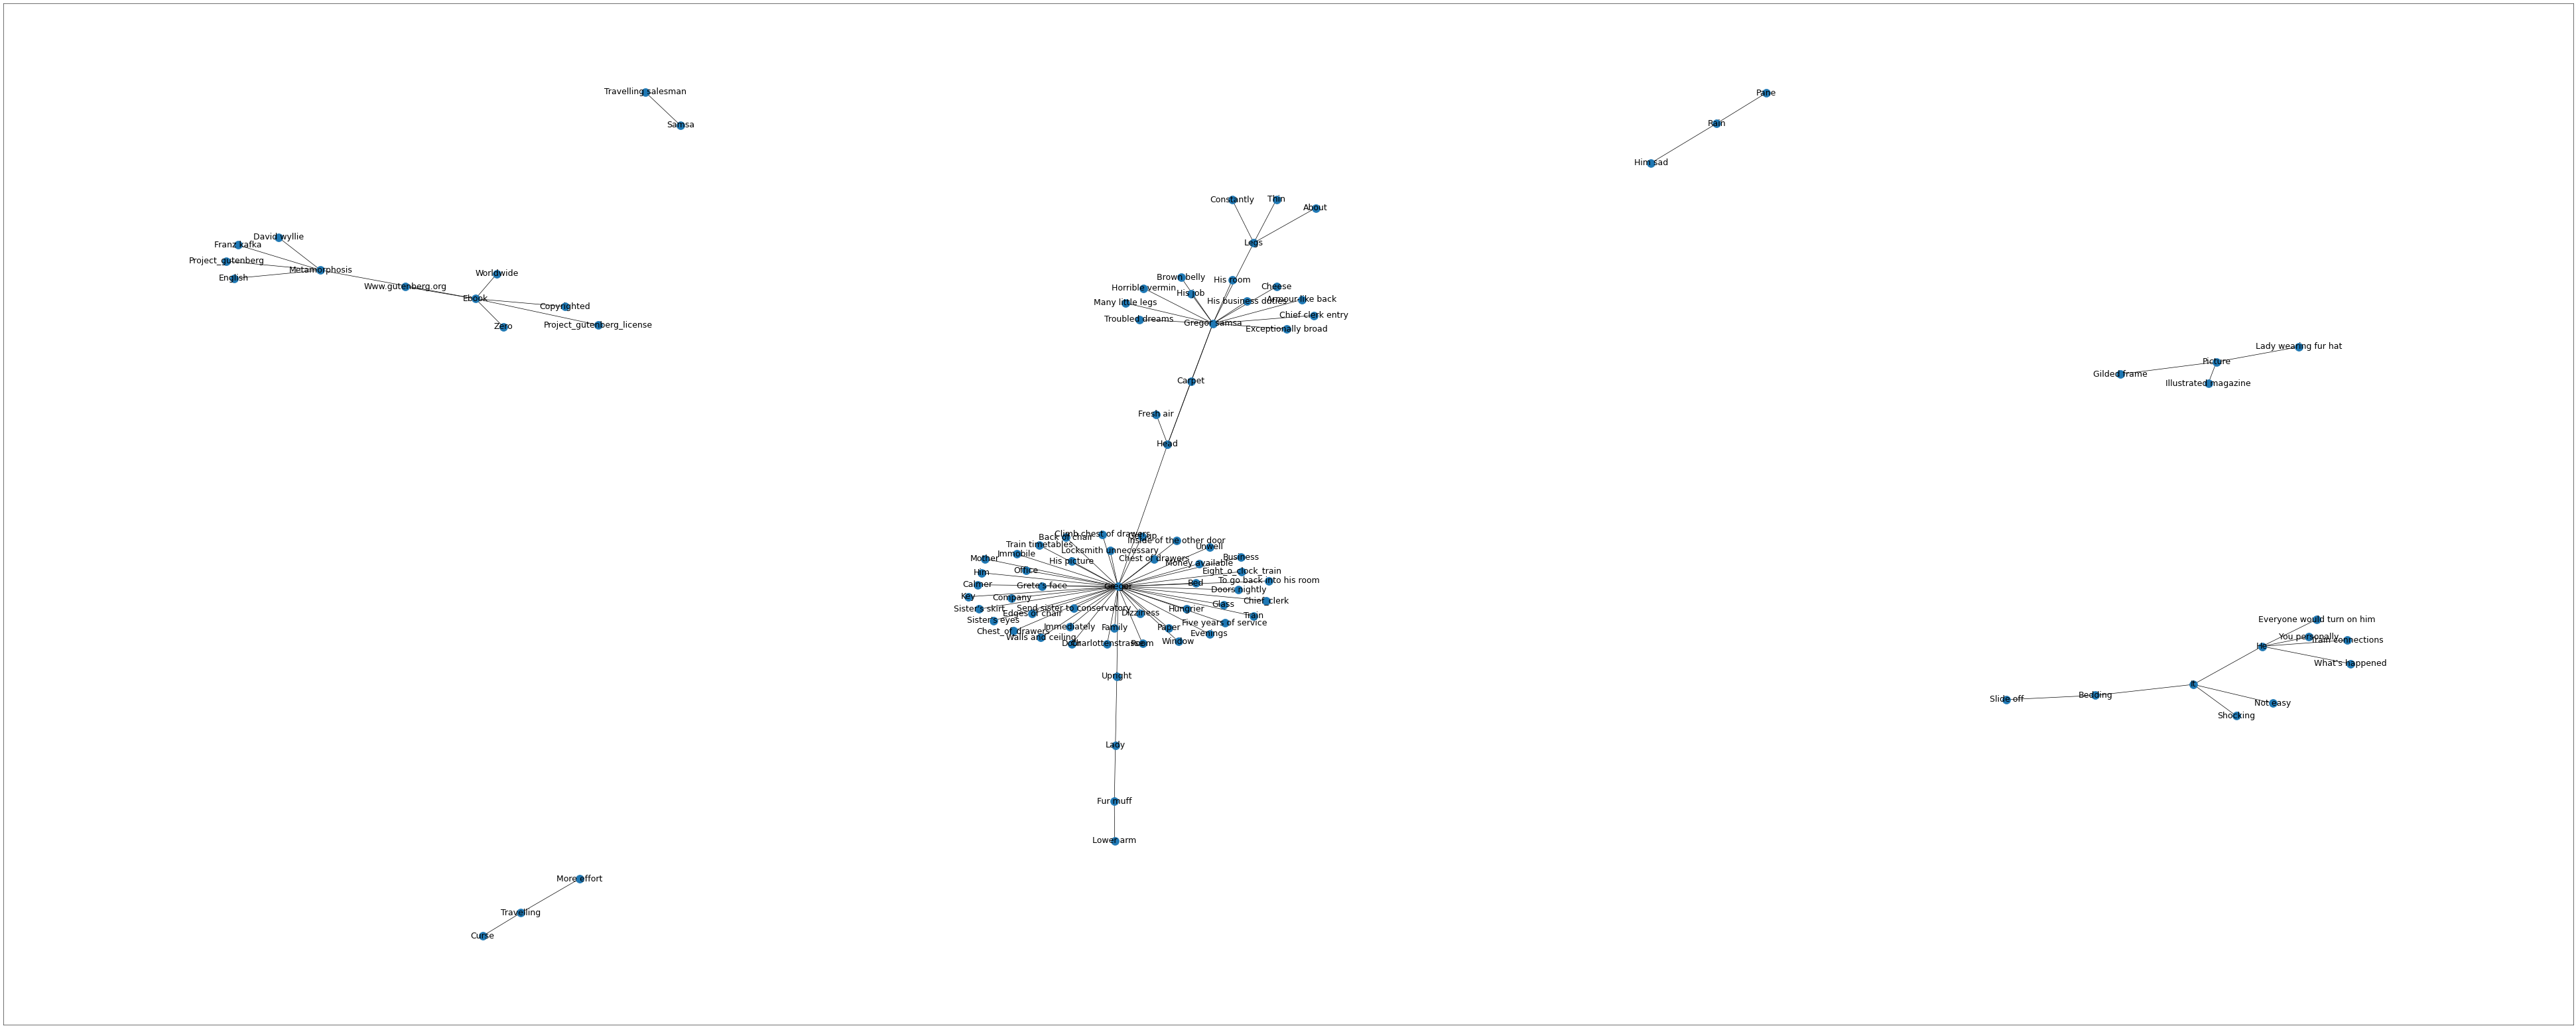

In [53]:
import networkx as nx
import matplotlib.pyplot as plt

fig = plt.figure(1, figsize=(100, 40), dpi=50)
nx.draw_networkx(kgraphindex.get_networkx_graph(), font_size=18)

### Using [Colbert Reranker](https://docs.llamaindex.ai/en/stable/examples/node_postprocessor/ColbertRerank/) with the Vector Store Index 

#### Other [Rerankers](https://docs.llamaindex.ai/en/stable/examples/node_postprocessor/CohereRerank/)

In [76]:
!pip install -q llama-index-postprocessor-colbert-rerank
!pip install -qU tokenizers
!pip install -qU transformers

In [24]:
import transformers
import transformers.utils as utils

print(f"Transformers version: {transformers.__version__}")

Transformers version: 4.57.6


In [21]:
from llama_index.postprocessor.colbert_rerank import ColbertRerank

colbert_reranker = ColbertRerank(top_n=5,
                                 model="colbert-ir/colbertv2.0",
                                 tokenizer="colbert-ir/colbertv2.0",
                                 #keep_retrieval_score=True,
                                )

query_engine = vectorstoreindex.as_query_engine(similarity_top_k=10,
                                                node_postprocessors=[colbert_reranker],
                                                )

response = query_engine.query("How the insect looks like?")

2026-01-16 15:07:10,166 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2026-01-16 15:07:29,831 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [22]:
print(response)

It’s a large insect with many very thin legs that wave about helplessly, and there’s a decayed apple lodged in its back.


In [34]:
for node in response.source_nodes:
    print(node.id_)
    print(node.node.get_content()[:120])
    print("reranking score: ", node.score)
    print("**********")

0aac3b79-7281-4e8a-ba2c-a7285b7a4716
He sat unyielding on his picture. He would rather jump at
Grete’s face.

But Grete’s words had made her mother quite 
reranking score:  0.5006259083747864
**********
da7c9c50-f002-485f-904d-46c04a203105
It wasn’t a dream. His room, a
proper human room although a little too small, lay peacefully between
its four familiar
reranking score:  0.49817806482315063
**********
0dbc585b-92d5-401e-a45a-bb2c2b2d0bf4
Maybe you can’t see it, but
I can. I don’t want to call this monster my brother, all I can say is:
we have to try and 
reranking score:  0.4942033290863037
**********
2ff3c969-53c9-40eb-9e8c-8a1adb70b524
They seemed to have realised his good intention and had only
been alarmed briefly. Now they all looked at him in unhapp
reranking score:  0.4898920953273773
**********
16b8cab1-a6b4-4d1e-87d5-fabae9518039
The bedding was hardly able to cover it and seemed ready to slide off
any moment. His many legs, pitifully thin compare
reranking score:  0.489811

### LlamaIndex [Notebook Examples](https://docs.llamaindex.ai/en/stable/examples/)